In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc

CPU times: user 1.68 s, sys: 1.2 s, total: 2.88 s
Wall time: 4.23 s


In [2]:
%%time
df = pd.read_csv("train.csv", low_memory = False)

CPU times: user 27.8 ms, sys: 6.09 ms, total: 33.9 ms
Wall time: 30.9 ms


In [3]:
df.head()


,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [4]:
%%time
df = add_datepart(df, 'date')

CPU times: user 75.3 ms, sys: 11.5 ms, total: 86.8 ms
Wall time: 84.4 ms


In [5]:
df.head()

,row_id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,Finland,KaggleMart,Kaggle Mug,329,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
1,1,Finland,KaggleMart,Kaggle Hat,520,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
2,2,Finland,KaggleMart,Kaggle Sticker,146,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
3,3,Finland,KaggleRama,Kaggle Mug,572,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09
4,4,Finland,KaggleRama,Kaggle Hat,911,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09


In [6]:
cond = (df.Year < 2018)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

print (len(train_idx), len(valid_idx))

19728 6570


In [7]:
splits = (list(train_idx), list(valid_idx))
procs = [Categorify, FillMissing]
dep_var = 'num_sold'
cont, cat = cont_cat_split(df,1, dep_var)

In [8]:
cont

['row_id', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Elapsed']

In [9]:
cont.remove('row_id')

In [10]:
cat

['country',
 'store',
 'product',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [11]:
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [12]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [13]:
m = DecisionTreeRegressor(max_leaf_nodes = 4)

In [14]:
%%time
m.fit(xs, y)

CPU times: user 29 ms, sys: 4.4 ms, total: 33.4 ms
Wall time: 29.7 ms


DecisionTreeRegressor(max_leaf_nodes=4)

In [15]:
def calculate_smape(m, valid_xs, valid_y):
    preds = list(m.predict(valid_xs))
    total = len(preds)
    smape = 0
    for i,j in zip(preds, valid_y) :
        diff = np.abs(i - j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smape += fin
        
    smape = (smape/total) * 100 
    
    return smape

In [16]:
calculate_smape(m, xs, y)

29.720652053183

In [17]:
calculate_smape(m, valid_xs, valid_y)

29.362668566080412

In [18]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """Draws a representation of a random forest in IPython."""
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

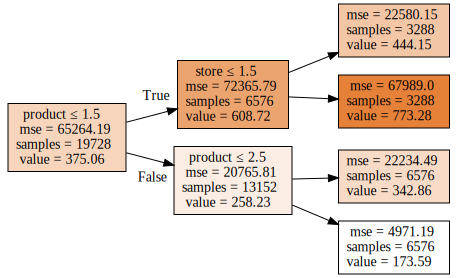

CPU times: user 24.4 ms, sys: 38.3 ms, total: 62.7 ms
Wall time: 90.4 ms


In [19]:
%%time
draw_tree(m, xs, size = 7, precision = 2)

In [20]:
m = DecisionTreeRegressor(min_samples_leaf = 25)

In [21]:
m.fit(xs, y)

DecisionTreeRegressor(min_samples_leaf=25)

In [22]:
calculate_smape(m, xs, y)

6.23894382308654

In [23]:
calculate_smape(m, valid_xs, valid_y)

9.413072138720967

In [25]:
test = pd.read_csv("test.csv")

In [26]:
test = add_datepart(test, 'date')

In [27]:
test["num_sold"] = 0

In [28]:
to_test = TabularPandas(test, procs, cat, cont, y_names = dep_var, splits = None)

In [29]:
test_xs = to_test.train.xs

In [30]:
preds_test = m.predict(test_xs)

In [31]:
preds_test

array([ 247.24      ,  375.19047619,   97.59459459, ...,  998.66666667,
       1183.68      ,  230.07407407])

In [32]:
ids = list(test["row_id"].values)
submission = pd.DataFrame()
submission["row_id"] = ids
submission["num_sold"] = list(preds_test)

In [33]:
submission.head()

,row_id,num_sold
0,26298,247.240000
1,26299,375.190476
2,26300,97.594595
3,26301,421.357143
4,26302,689.461538


In [34]:
submission.to_csv("submission.csv", index = False)